### Setup the environment

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import applications
%matplotlib inline
from keras.utils.vis_utils import plot_model
import pydot
from keras import regularizers
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")
from keras.engine.topology import Layer
from keras import backend as K
from keras.layers import Conv2D, BatchNormalization, Concatenate, MaxPooling2D, Activation
from keras.layers import Input, Flatten, Reshape
from keras.models import Model
from keras.layers.core import K as Kc
import keras
keras.__version__

/home/RaviRani/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

### Helper Functions to draw confusion matrix and plotting learning curves 

In [2]:
### Declaraing paths to images
train_dir = "chest_xray/train/"
test_dir =  "chest_xray/test/"
validation_dir =  "chest_xray/val/"


map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def normalizeImage(img_file_test):
    img_file_test = skimage.transform.resize(img_file_test, (150, 150, 3))
    #print(img_file_test.shape)
    img_file_test_data=img_file_test.reshape(img_file_test.shape[0],-1)
    img_size=np.shape(img_file_test_data)[1]
    mean=np.mean(img_file_test_data,axis=1)
    meanT=mean.reshape(len(mean),1)
    stds=np.std(img_file_test_data,axis=1)
    stdsT=stds.reshape(len(stds),1)
    adj_stds=np.maximum(stdsT,1.0/np.sqrt(img_size))
    norm=(img_file_test-meanT)/adj_stds
    return norm



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    #img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    img_file=normalizeImage(img_file)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [3]:
#read training data,test data and  validation data)
# we use categorize the data in 3 if the iamge is normal the label=0
# if the image is Pneumonia then label=1
# if the image is none of the above label=2

X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)
X_val, y_val= get_data(validation_dir)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_valHot = to_categorical(y_val, num_classes = 2)

100%|██████████| 9/9 [00:00<00:00, 11.58it/s]


## Plot sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


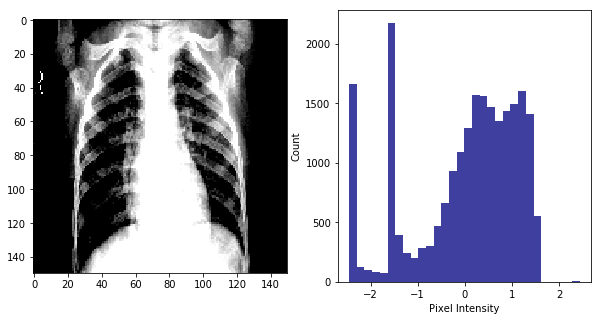

In [4]:
import cv2
# Plot Image and Image histogram
def plotImagePixelHistogram(img):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(img[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(img[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(img[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    

#print(X_train[1])
plotImagePixelHistogram(X_train[1])    

In [5]:
print(X_train[1].shape)

(150, 150, 3)


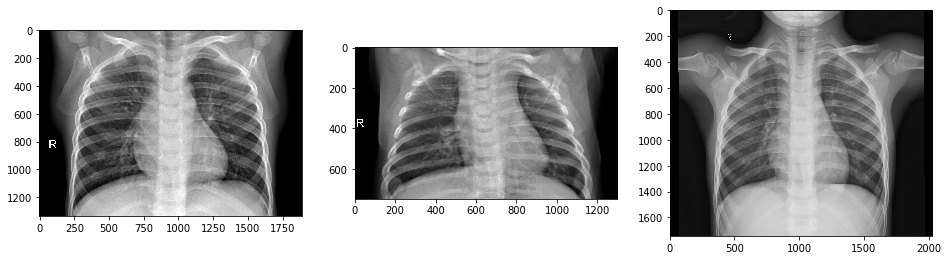

In [6]:
## Method to plot 3 images at a time.
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
    
#Plot 3 normal Images
multipleImages = glob('chest_xray/test//NORMAL/**')
plotThreeImages(multipleImages)

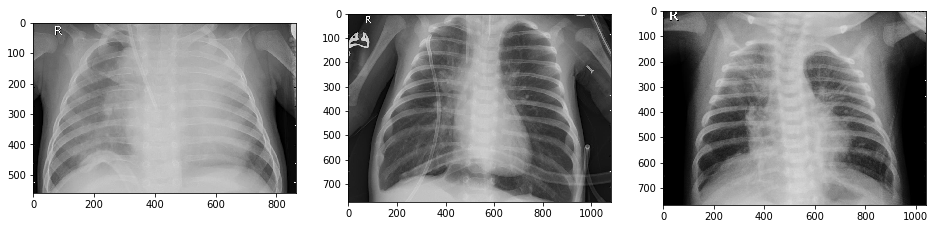

In [7]:
#Plot 3 images with PNEUMONIA
multipleImages = glob('chest_xray/test/PNEUMONIA/**')
plotThreeImages(multipleImages)

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


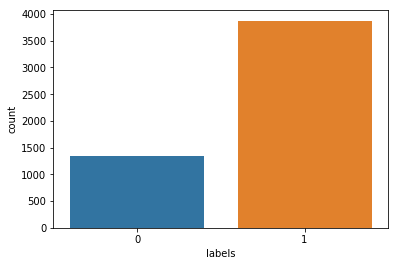

In [8]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#before sampling

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


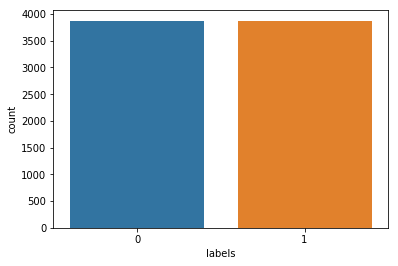

In [9]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_valShape = X_val.shape[1]*X_val.shape[2]*X_val.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
X_valFlat = X_val.reshape(X_val.shape[0], X_valShape)
Y_train = y_train
Y_test = y_test
Y_val = y_val

ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
X_valRos, Y_valRos = ros.fit_sample(X_valFlat, Y_val)
# Hot Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
Y_valRosHot = to_categorical(Y_valRos, num_classes = 2)
# Make Data 2D again
height, width, channels = 150,150,3
for i in range(len(X_trainRos)):
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
for i in range(len(X_valRos)):
    X_valRosReshaped = X_valRos.reshape(len(X_valRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)
#plot after upsampling

In [10]:
print(X_trainRosReshaped.shape)

(7750, 150, 150, 3)


## Developing Manual Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

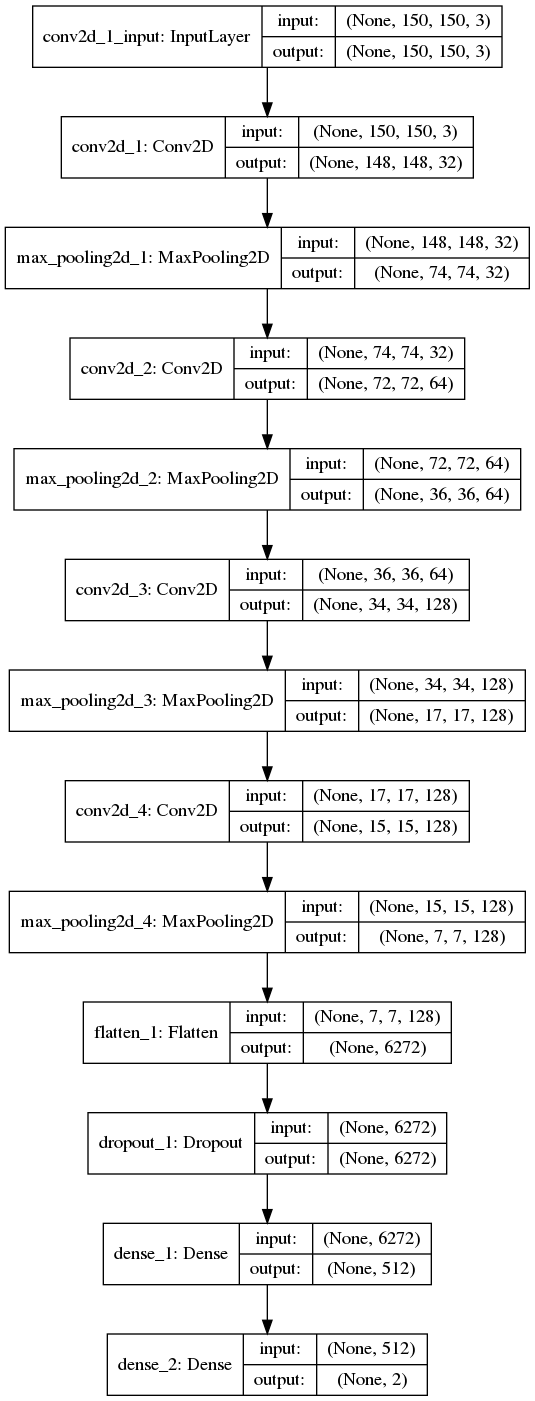

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-4), 
                  metrics=['accuracy'])
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='model_plot.png') 

In [12]:
history = model.fit(X_trainRosReshaped, Y_trainRosHot, epochs=30, batch_size=32,validation_data=(X_testRosReshaped, Y_testRosHot))

Train on 7750 samples, validate on 780 samples
Epoch 1/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.2391 - acc: 0.8987 - val_loss: 0.7856 - val_acc: 0.7141
Epoch 2/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.1178 - acc: 0.9550 - val_loss: 0.8608 - val_acc: 0.7564
Epoch 3/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.0900 - acc: 0.9661 - val_loss: 0.8498 - val_acc: 0.7564
Epoch 4/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.0748 - acc: 0.9729 - val_loss: 1.3544 - val_acc: 0.7090
Epoch 5/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.0646 - acc: 0.9773 - val_loss: 1.8209 - val_acc: 0.6526
Epoch 6/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.0607 - acc: 0.9765 - val_loss: 0.9967 - val_acc: 0.7526
Epoch 7/30
7750/7750 [==============================] - 109s 14ms/step - loss: 0.0493 - acc: 0.9839 - val_loss: 1.2282 - val_acc: 0

## Evaluate with Test data

In [13]:
model.evaluate(X_testRosReshaped, y = Y_testRosHot, batch_size=32, verbose=1)

780/780 [==============================] - 3s 4ms/step


[2.6158427097429664, 0.7423076926133572]


Keras CNN - accuracy: 0.7423076926133572 


               precision    recall  f1-score   support

 No Pneumonia       0.99      0.49      0.66       390
Yes Pneumonia       0.66      0.99      0.79       390

  avg / total       0.83      0.74      0.72       780



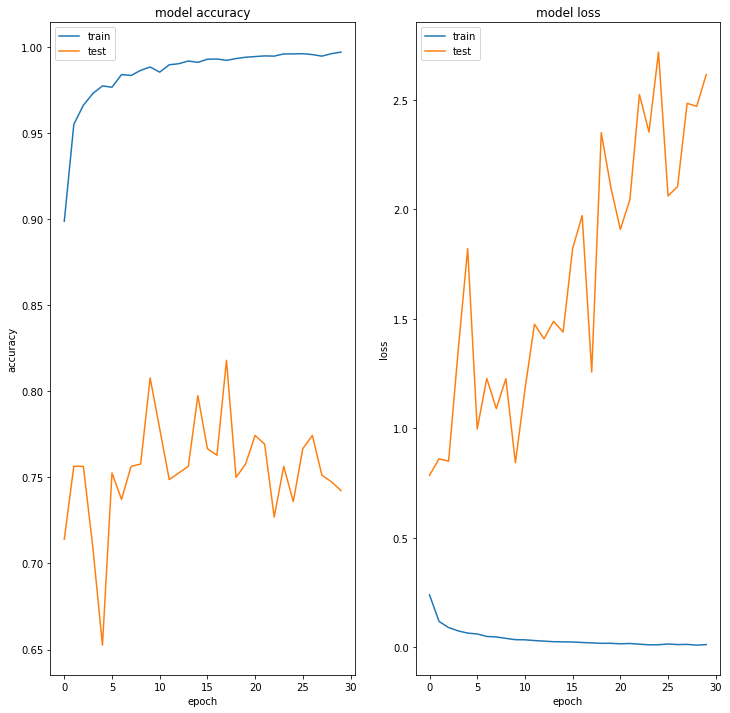

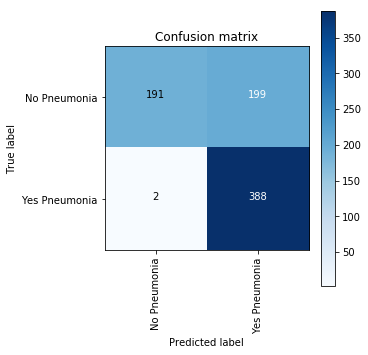

In [14]:
score = model.evaluate(X_testRosReshaped,Y_testRosHot, verbose=0)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_testRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_testRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_testRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

## Evaluate with Validation data

In [15]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 0s 4ms/step


[0.03489968553185463, 1.0]


Keras CNN - accuracy: 1.0 


               precision    recall  f1-score   support

 No Pneumonia       1.00      1.00      1.00         8
Yes Pneumonia       1.00      1.00      1.00         8

  avg / total       1.00      1.00      1.00        16



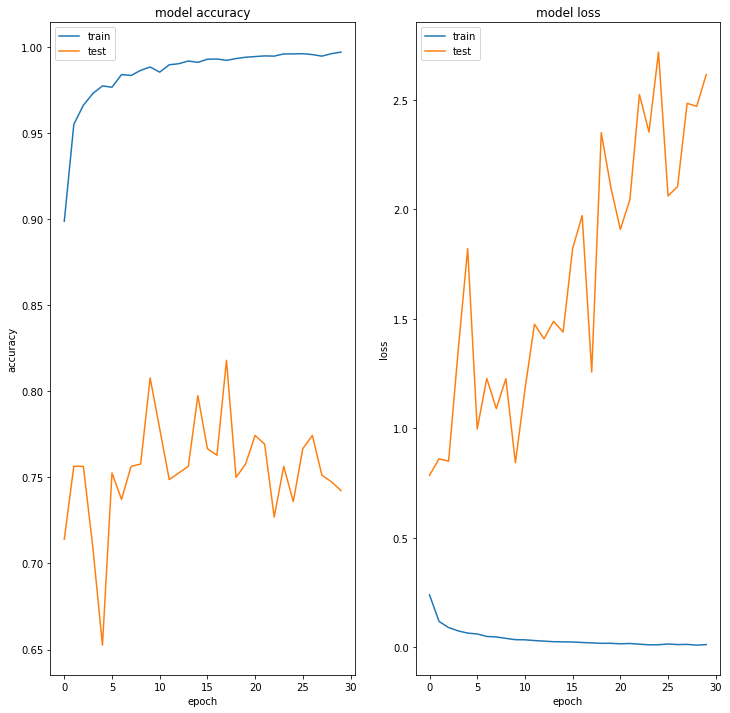

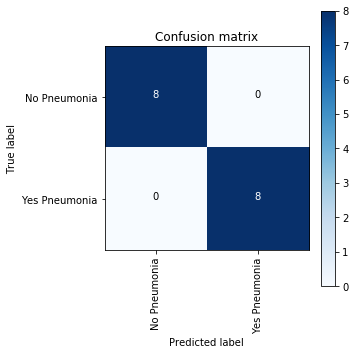

In [16]:
score = model.evaluate(X_valRosReshaped,Y_valRosHot, verbose=0)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_valRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_valRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_valRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

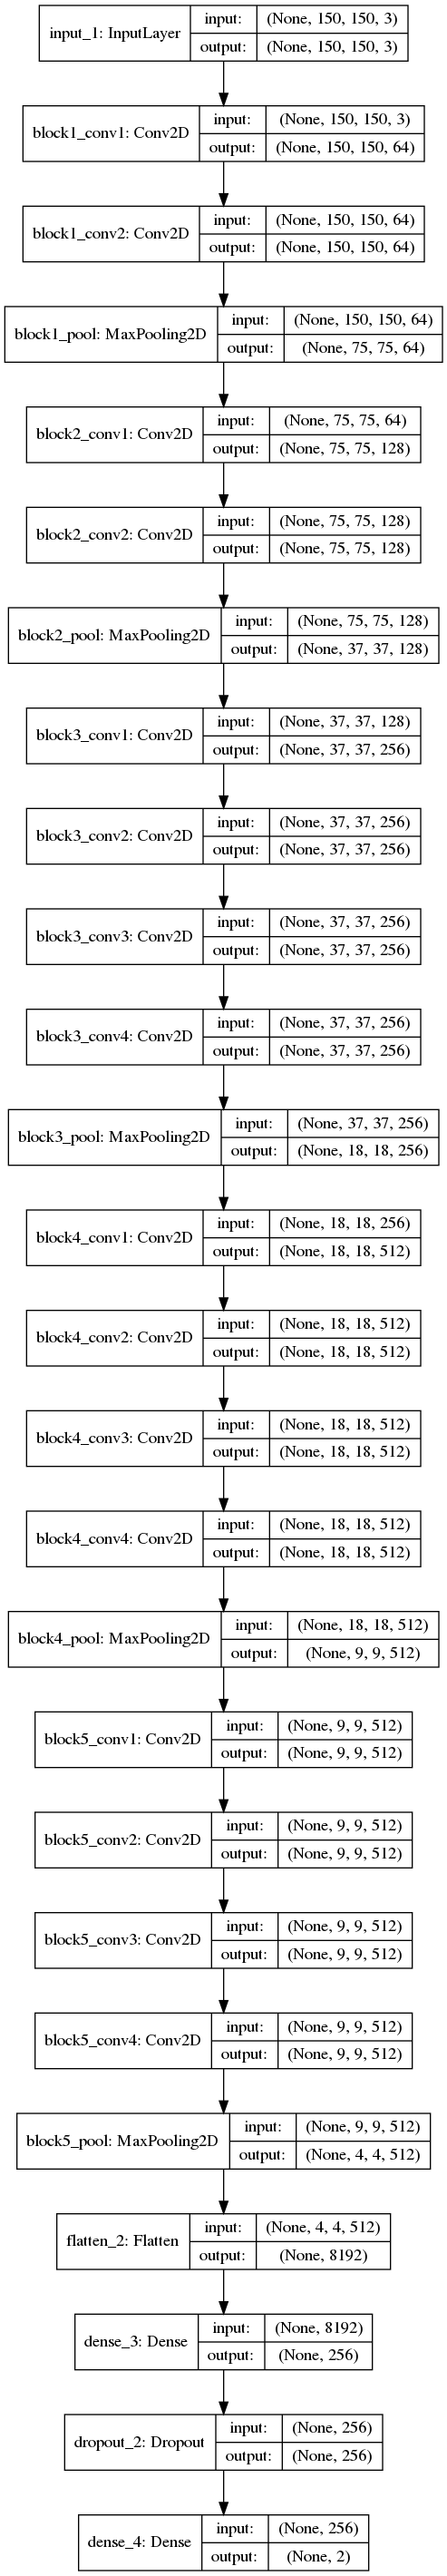

In [17]:
model = applications.VGG19(include_top=False, weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=(150, 150, 3))
base_model=model
x=model.output
x=Flatten()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
model = Model(inputs=model.input, outputs=x)
for layer in base_model.layers:
        layer.trainable = False
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_vgg19_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='model_vgg19_plot.png') 

In [18]:
history = model.fit(X_trainRosReshaped, Y_trainRosHot, epochs=30, batch_size=32,validation_data=(X_testRosReshaped, Y_testRosHot))

Train on 7750 samples, validate on 780 samples
Epoch 1/30
7750/7750 [==============================] - 493s 64ms/step - loss: 0.1720 - acc: 0.9312 - val_loss: 0.7191 - val_acc: 0.7526
Epoch 2/30
7750/7750 [==============================] - 494s 64ms/step - loss: 0.0966 - acc: 0.9627 - val_loss: 0.9429 - val_acc: 0.7500
Epoch 3/30
7750/7750 [==============================] - 494s 64ms/step - loss: 0.0734 - acc: 0.9745 - val_loss: 0.5497 - val_acc: 0.8538
Epoch 4/30
7750/7750 [==============================] - 494s 64ms/step - loss: 0.0589 - acc: 0.9791 - val_loss: 0.7546 - val_acc: 0.8321
Epoch 5/30
7750/7750 [==============================] - 493s 64ms/step - loss: 0.0548 - acc: 0.9830 - val_loss: 1.2112 - val_acc: 0.7256
Epoch 6/30
7750/7750 [==============================] - 491s 63ms/step - loss: 0.0415 - acc: 0.9862 - val_loss: 1.0346 - val_acc: 0.7897
Epoch 7/30
7750/7750 [==============================] - 491s 63ms/step - loss: 0.0391 - acc: 0.9868 - val_loss: 1.1436 - val_acc: 0

## Evaluate with Test data

In [19]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 1s 58ms/step


[0.0011177657870575786, 1.0]


 CNN - accuracy: 0.7410256413313059 


               precision    recall  f1-score   support

 No Pneumonia       0.98      0.49      0.65       390
Yes Pneumonia       0.66      0.99      0.79       390

  avg / total       0.82      0.74      0.72       780



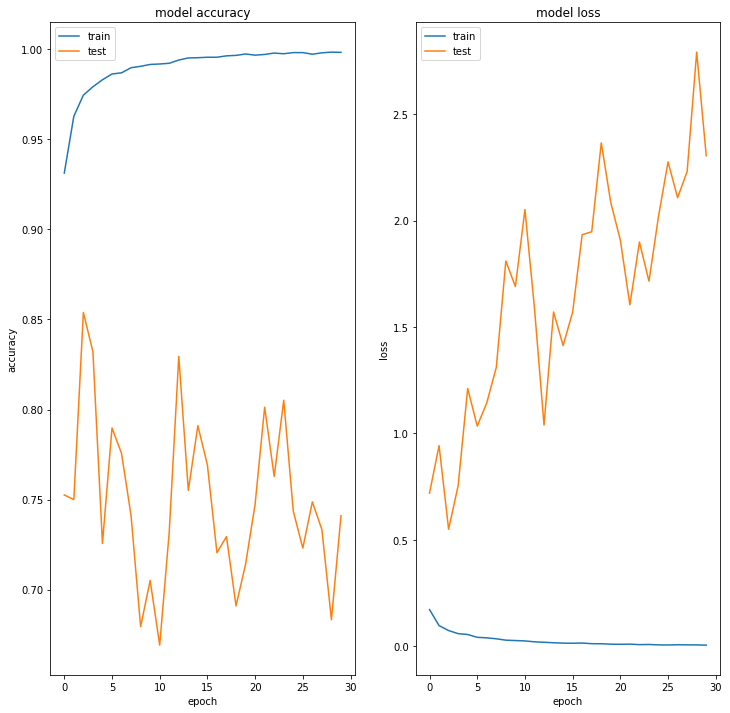

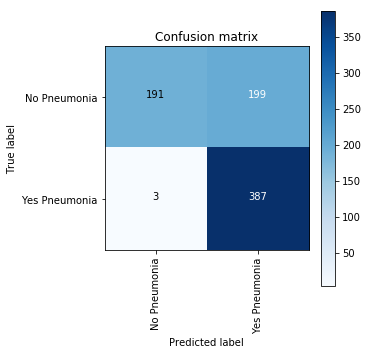

In [20]:
score = model.evaluate(X_testRosReshaped,Y_testRosHot, verbose=0)
print('\n CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_testRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_testRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_testRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

## Evaluate with Validation data

In [21]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 1s 58ms/step


[0.0011177657870575786, 1.0]


Keras CNN - accuracy: 1.0 


               precision    recall  f1-score   support

 No Pneumonia       1.00      1.00      1.00         8
Yes Pneumonia       1.00      1.00      1.00         8

  avg / total       1.00      1.00      1.00        16



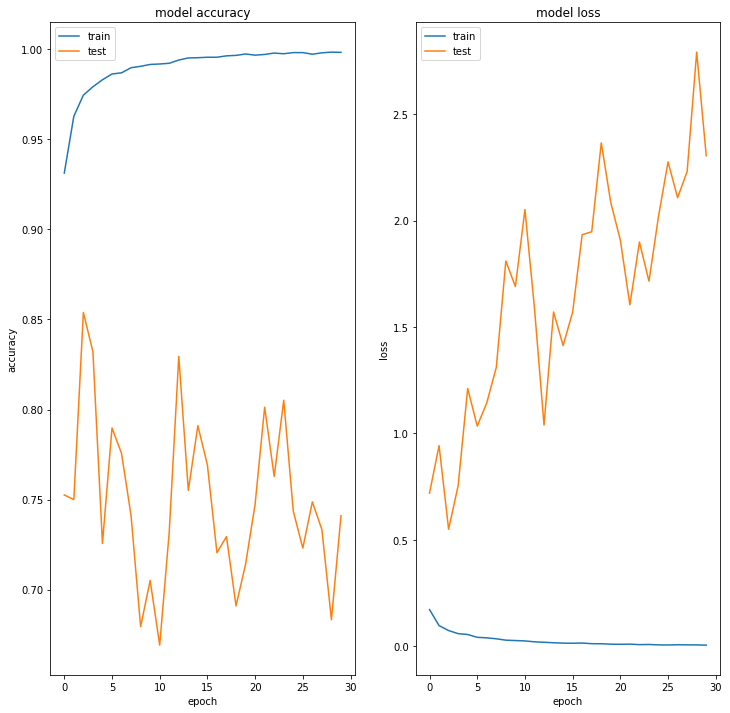

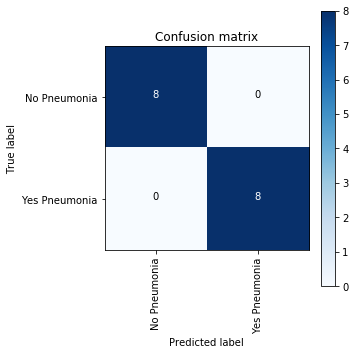

In [22]:
score = model.evaluate(X_valRosReshaped,Y_valRosHot, verbose=0)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_valRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_valRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_valRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

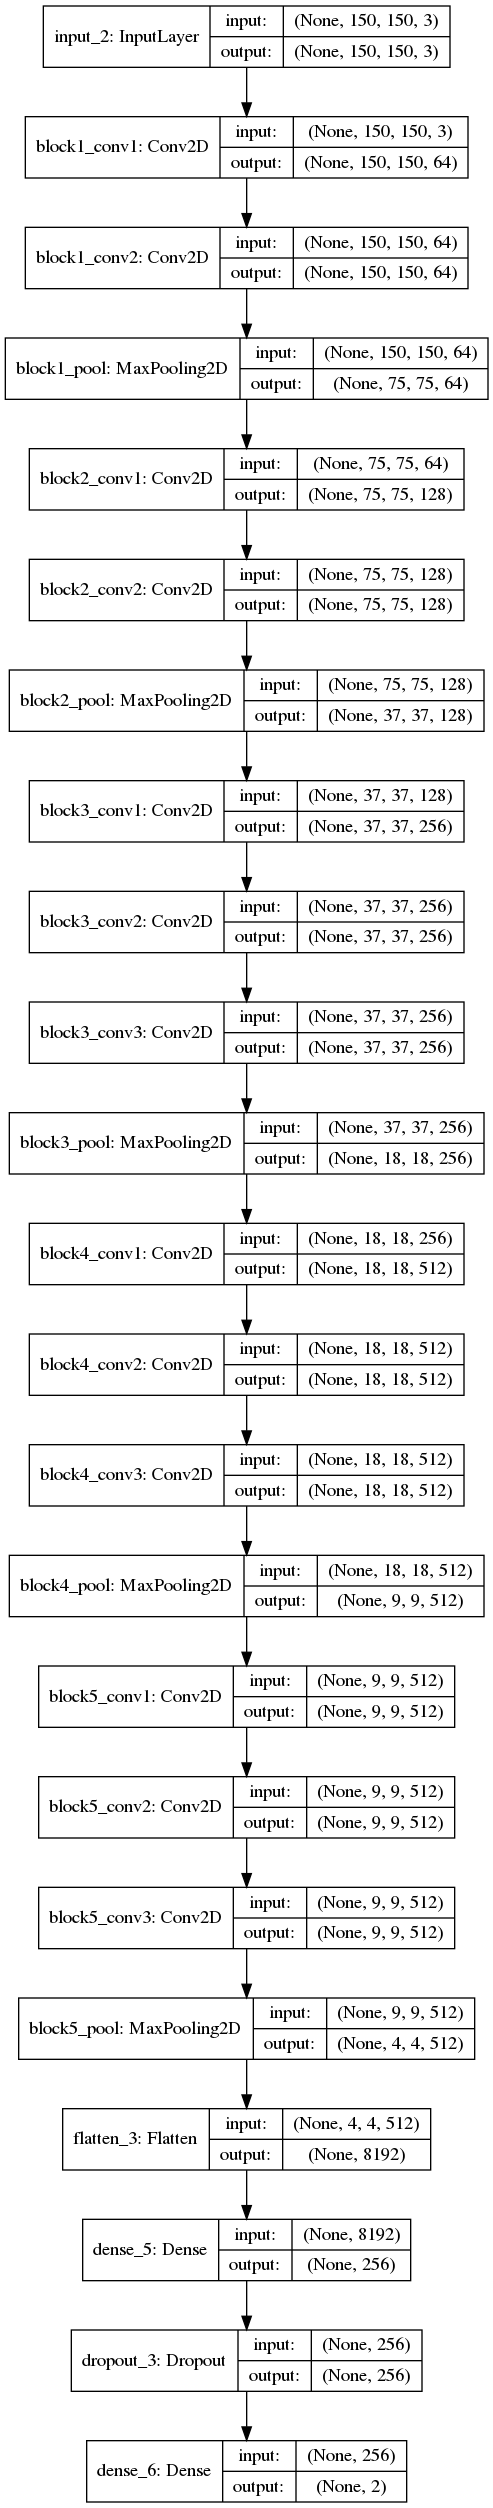

In [23]:
model = applications.VGG16(include_top=False, weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=(150, 150, 3))
base_model=model
x=model.output
x=Flatten()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
model = Model(inputs=model.input, outputs=x)
for layer in base_model.layers:
        layer.trainable = False
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model_vgg16_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='model_vgg16_plot.png') 

In [24]:
history = model.fit(X_trainRosReshaped, Y_trainRosHot, epochs=30, batch_size=32,validation_data=(X_testRosReshaped, Y_testRosHot))

Train on 7750 samples, validate on 780 samples
Epoch 1/30
7750/7750 [==============================] - 407s 52ms/step - loss: 0.1571 - acc: 0.9361 - val_loss: 0.8213 - val_acc: 0.7218
Epoch 2/30
7750/7750 [==============================] - 406s 52ms/step - loss: 0.0816 - acc: 0.9717 - val_loss: 1.2483 - val_acc: 0.6718
Epoch 3/30
7750/7750 [==============================] - 407s 52ms/step - loss: 0.0589 - acc: 0.9786 - val_loss: 1.0725 - val_acc: 0.7385
Epoch 4/30
7750/7750 [==============================] - 407s 53ms/step - loss: 0.0483 - acc: 0.9830 - val_loss: 1.5445 - val_acc: 0.6692
Epoch 5/30
7750/7750 [==============================] - 407s 53ms/step - loss: 0.0391 - acc: 0.9871 - val_loss: 1.0986 - val_acc: 0.7705
Epoch 6/30
7750/7750 [==============================] - 407s 52ms/step - loss: 0.0340 - acc: 0.9880 - val_loss: 0.9522 - val_acc: 0.7872
Epoch 7/30
7750/7750 [==============================] - 406s 52ms/step - loss: 0.0299 - acc: 0.9897 - val_loss: 1.7074 - val_acc: 0

## Evaluate with Test data

In [25]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 1s 49ms/step


[0.0024355596397072077, 1.0]


 CNN - accuracy: 0.7205128208184853 


               precision    recall  f1-score   support

 No Pneumonia       0.97      0.45      0.62       390
Yes Pneumonia       0.64      0.99      0.78       390

  avg / total       0.81      0.72      0.70       780



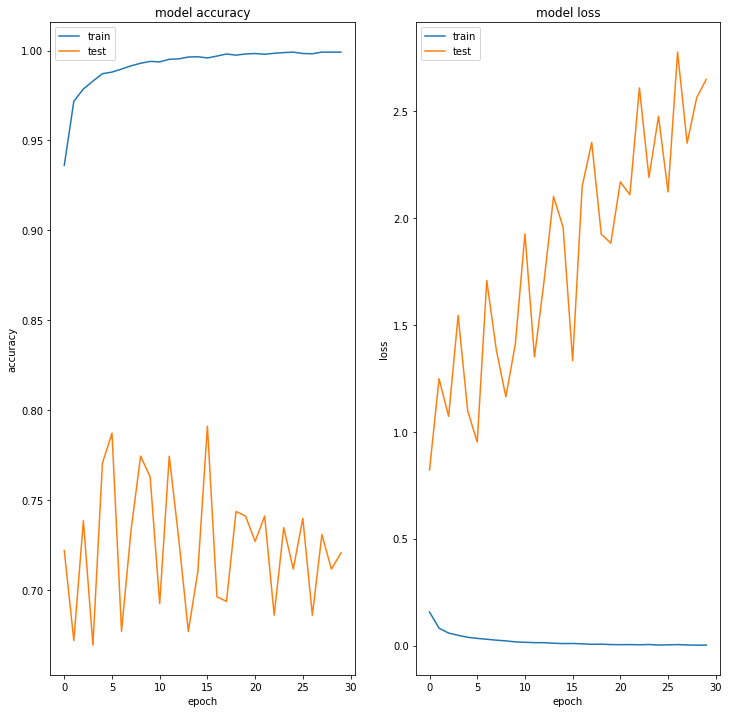

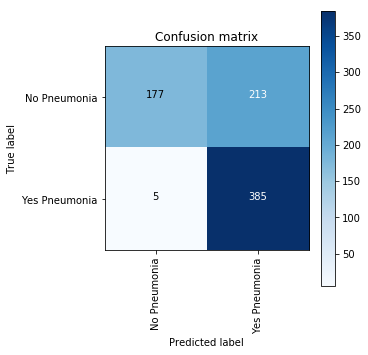

In [26]:
score = model.evaluate(X_testRosReshaped,Y_testRosHot, verbose=0)
print('\n CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_testRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_testRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_testRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

## Evaluate with Validation data

In [27]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 1s 48ms/step


[0.0024355596397072077, 1.0]


Keras CNN - accuracy: 1.0 


               precision    recall  f1-score   support

 No Pneumonia       1.00      1.00      1.00         8
Yes Pneumonia       1.00      1.00      1.00         8

  avg / total       1.00      1.00      1.00        16



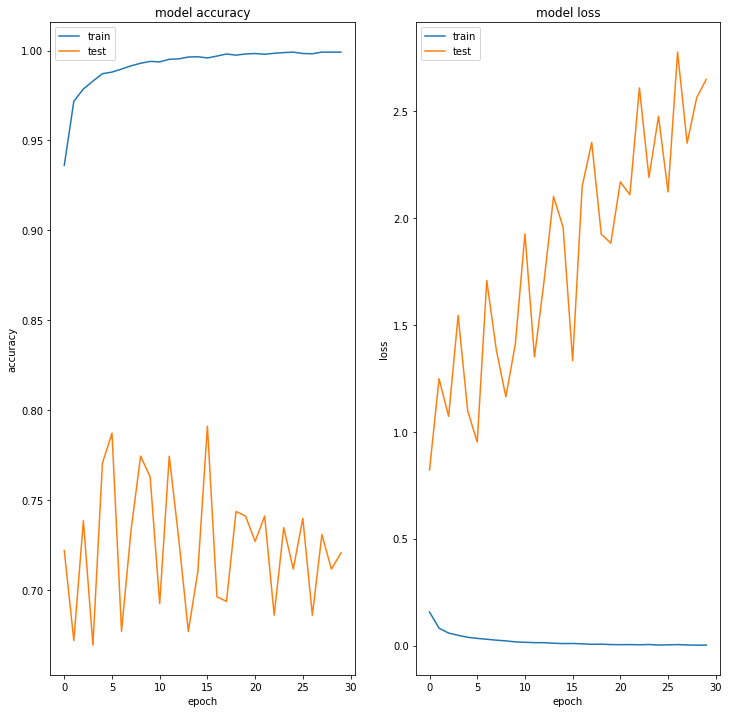

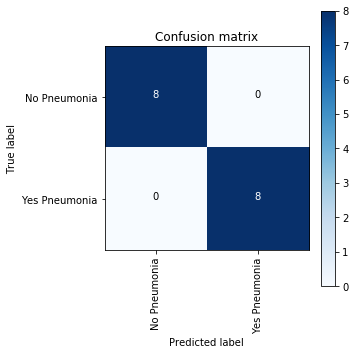

In [28]:
score = model.evaluate(X_valRosReshaped,Y_valRosHot, verbose=0)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_valRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_valRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_valRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

## L2 Reguralization  on the first model

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.00001),activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-4), 
                  metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [30]:
history = model.fit(X_trainRosReshaped, Y_trainRosHot, epochs=30, batch_size=32,validation_data=(X_testRosReshaped, Y_testRosHot))

Train on 7750 samples, validate on 780 samples
Epoch 1/30
7750/7750 [==============================] - 108s 14ms/step - loss: 0.2560 - acc: 0.8972 - val_loss: 0.3067 - val_acc: 0.8936
Epoch 2/30
7750/7750 [==============================] - 107s 14ms/step - loss: 0.1267 - acc: 0.9555 - val_loss: 0.6226 - val_acc: 0.7974
Epoch 3/30
7750/7750 [==============================] - 108s 14ms/step - loss: 0.0980 - acc: 0.9661 - val_loss: 0.4949 - val_acc: 0.8423
Epoch 4/30
7750/7750 [==============================] - 107s 14ms/step - loss: 0.0841 - acc: 0.9729 - val_loss: 0.6954 - val_acc: 0.8077
Epoch 5/30
7750/7750 [==============================] - 108s 14ms/step - loss: 0.0678 - acc: 0.9788 - val_loss: 0.7829 - val_acc: 0.7987
Epoch 6/30
7750/7750 [==============================] - 107s 14ms/step - loss: 0.0587 - acc: 0.9808 - val_loss: 1.0098 - val_acc: 0.7590
Epoch 7/30
7750/7750 [==============================] - 107s 14ms/step - loss: 0.0528 - acc: 0.9834 - val_loss: 0.9493 - val_acc: 0

## Evaluate with Test data

In [31]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 0s 4ms/step


[0.28017890453338623, 0.875]


 CNN - accuracy: 0.746153846459511 


               precision    recall  f1-score   support

 No Pneumonia       0.99      0.50      0.66       390
Yes Pneumonia       0.66      0.99      0.80       390

  avg / total       0.83      0.75      0.73       780



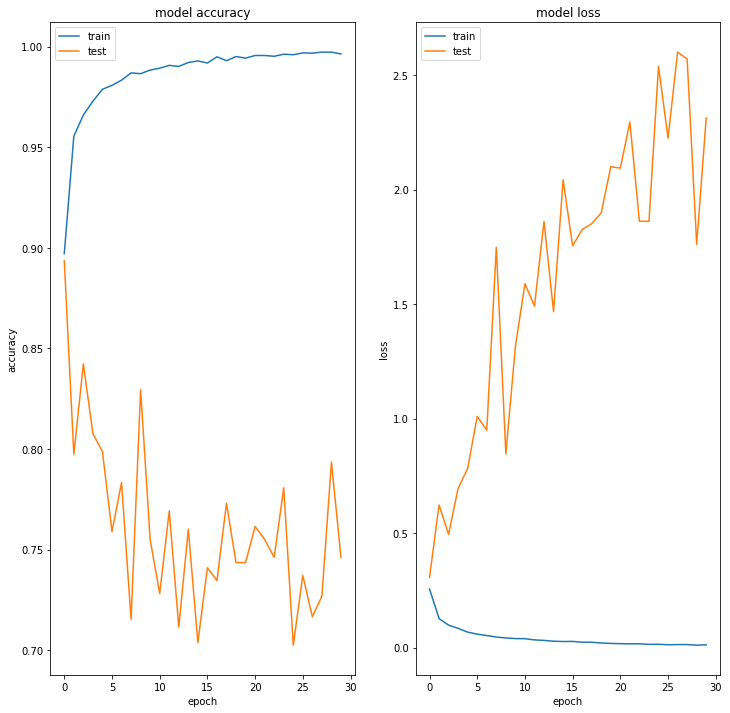

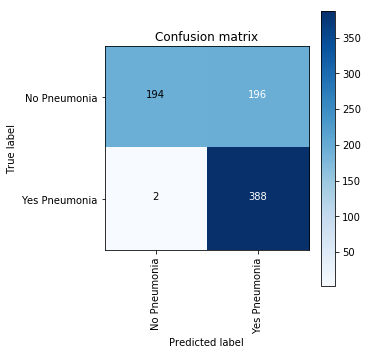

In [32]:
score = model.evaluate(X_testRosReshaped,Y_testRosHot, verbose=0)
print('\n CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_testRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_testRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_testRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

## Evaluate with Validation data

In [33]:
model.evaluate(X_valRosReshaped, y = Y_valRosHot, batch_size=32, verbose=1)

16/16 [==============================] - 0s 4ms/step


[0.28017890453338623, 0.875]


Keras CNN - accuracy: 0.875 


               precision    recall  f1-score   support

 No Pneumonia       1.00      0.75      0.86         8
Yes Pneumonia       0.80      1.00      0.89         8

  avg / total       0.90      0.88      0.87        16



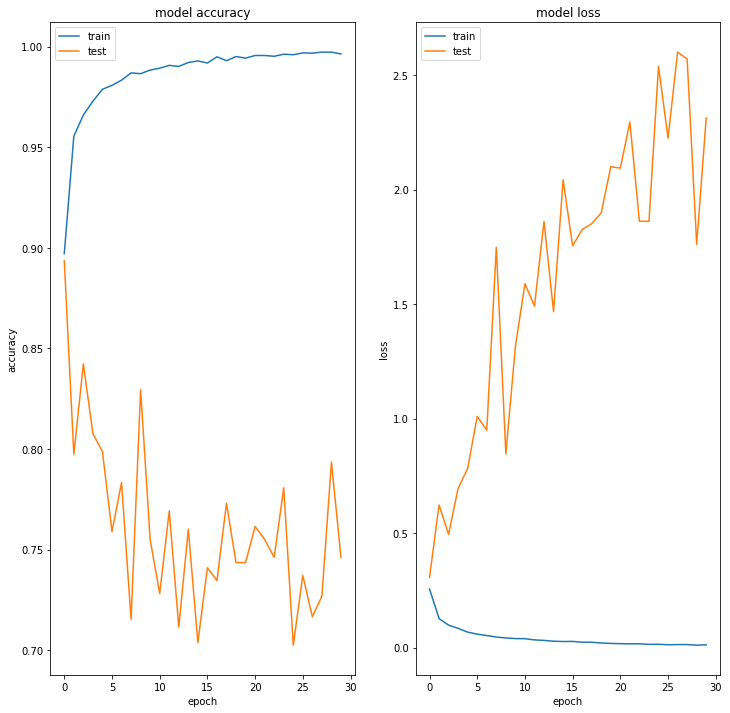

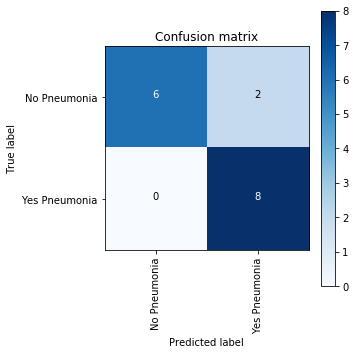

In [34]:
score = model.evaluate(X_valRosReshaped,Y_valRosHot, verbose=0)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(X_valRosReshaped)
print('\n', sklearn.metrics.classification_report(np.where(Y_valRosHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_valRosHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()